# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

'2.2.2+cu121'

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15528, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 15528 (delta 82), reused 186 (delta 42), pack-reused 15275
Receiving objects: 100% (15528/15528), 6.40 MiB | 20.35 MiB/s, done.
Resolving deltas: 100% (11196/11196), done.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 868.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("zerowaste_train", {}, "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/labels.json", "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/data")

In [ ]:
zerowaste_metadata = MetadataCatalog.get("zerowaste_train")
dataset_dicts = DatasetCatalog.get("zerowaste_train")

[04/08 12:08:52 d2.data.datasets.coco]: Loading /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/labels.json takes 3.69 seconds.
[04/08 12:08:52 d2.data.datasets.coco]: Loaded 3002 images in COCO format from /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/labels.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



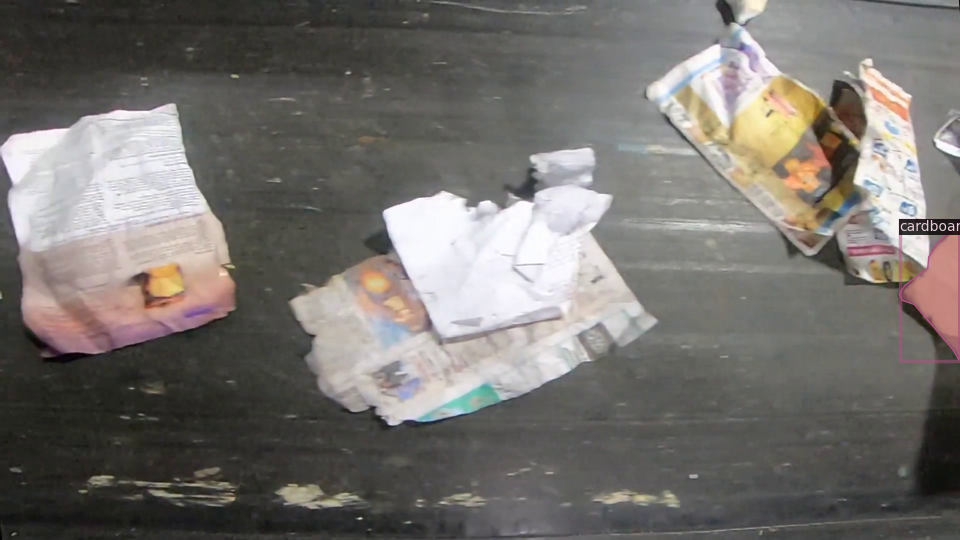

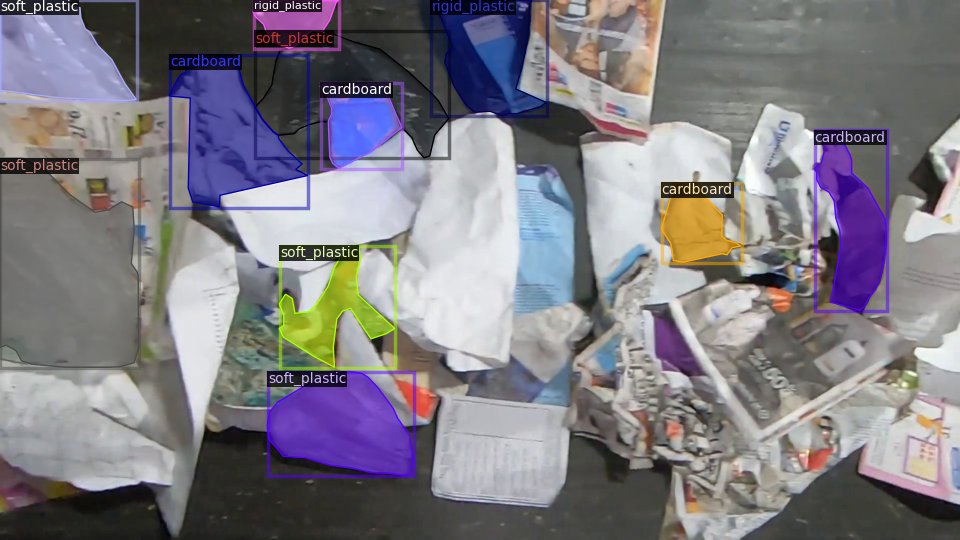

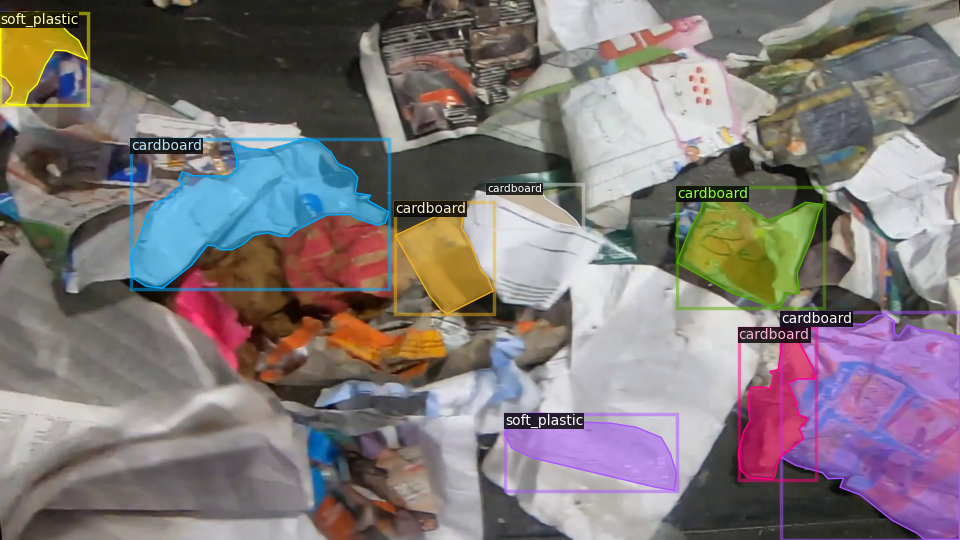

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=zerowaste_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("zerowaste_val", {}, "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/val/labels.json", "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/val/data")

In [ ]:
zerowaste_metadata_val = MetadataCatalog.get("zerowaste_val")
dataset_dicts_val = DatasetCatalog.get("zerowaste_val")

[04/08 12:09:27 d2.data.datasets.coco]: Loading /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/val/labels.json takes 1.90 seconds.
[04/08 12:09:27 d2.data.datasets.coco]: Loaded 572 images in COCO format from /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/val/labels.json


In [ ]:
from detectron2.evaluation import COCOEvaluator
from detectron2.evaluation import DatasetEvaluators

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("zerowaste_test", {}, "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/test/labels.json", "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/test/data")

In [ ]:
zerowaste_metadata_test = MetadataCatalog.get("zerowaste_test")
dataset_dicts_test = DatasetCatalog.get("zerowaste_test")

[04/08 12:09:28 d2.data.datasets.coco]: Loading /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/test/labels.json takes 1.34 seconds.
[04/08 12:09:28 d2.data.datasets.coco]: Loaded 929 images in COCO format from /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/test/labels.json


In [ ]:
!python /content/detectron2_repo/projects/TridentNet/train_net.py --config-file /content/detectron2_repo/projects/TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml --num-gpus 1 --resume --dist-url /content/drive/MyDrive/CMP-49413/zerowaste-f-final/TridentNet-2.0

Command Line Args: Namespace(config_file='/content/detectron2_repo/projects/TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml', resume=True, eval_only=False, num_gpus=1, num_machines=1, machine_rank=0, dist_url='/content/drive/MyDrive/CMP-49413/zerowaste-f-final/TridentNet-2.0', opts=[])
[04/08 13:19:37 detectron2]: Rank of current process: 0. World size: 1
[04/08 13:19:38 detectron2]: Environment info:
-------------------------------  -----------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy                            1.25.2
detectron2                       0.6 @/content/detectron2_repo/detectron2
Compiler                         GCC 11.4
CUDA compiler                    CUDA 12.2
detectron2 arch flags            8.0
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.2.2+cu121 @/usr/local/lib/python3.10/dist-packages/torch

In [ ]:
!python /content/detectron2_repo/projects/TridentNet/train_net.py --config-file /content/detectron2_repo/projects/TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml --eval-only MODEL.WEIGHTS /content/drive/MyDrive/CMP-49413/zerowaste-f-final/TridentNet_10k/model_final.pth

Command Line Args: Namespace(config_file='/content/detectron2_repo/projects/TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml', resume=False, eval_only=True, num_gpus=1, num_machines=1, machine_rank=0, dist_url='tcp://127.0.0.1:49152', opts=['MODEL.WEIGHTS', '/content/drive/MyDrive/CMP-49413/zerowaste-f-final/TridentNet_10k/model_final.pth'])
[04/08 01:49:54 detectron2]: Rank of current process: 0. World size: 1
[04/08 01:49:55 detectron2]: Environment info:
-------------------------------  -----------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy                            1.25.2
detectron2                       0.6 @/content/detectron2_repo/detectron2
Compiler                         GCC 11.4
CUDA compiler                    CUDA 12.2
detectron2 arch flags            8.0
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.

[04/08 14:12:31 detectron2]: Rank of current process: 0. World size: 1
[04/08 14:12:31 detectron2]: Rank of current process: 0. World size: 1
[04/08 14:12:32 detectron2]: Environment info:
-------------------------------  -----------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy                            1.25.2
detectron2                       0.6 @/content/detectron2_repo/detectron2
Compiler                         GCC 11.4
CUDA compiler                    CUDA 12.2
detectron2 arch flags            8.0
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.2.2+cu121 @/usr/local/lib/python3.10/dist-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            NVIDIA A100-SXM4-40GB (arch=8.0)
Driver version                   535.

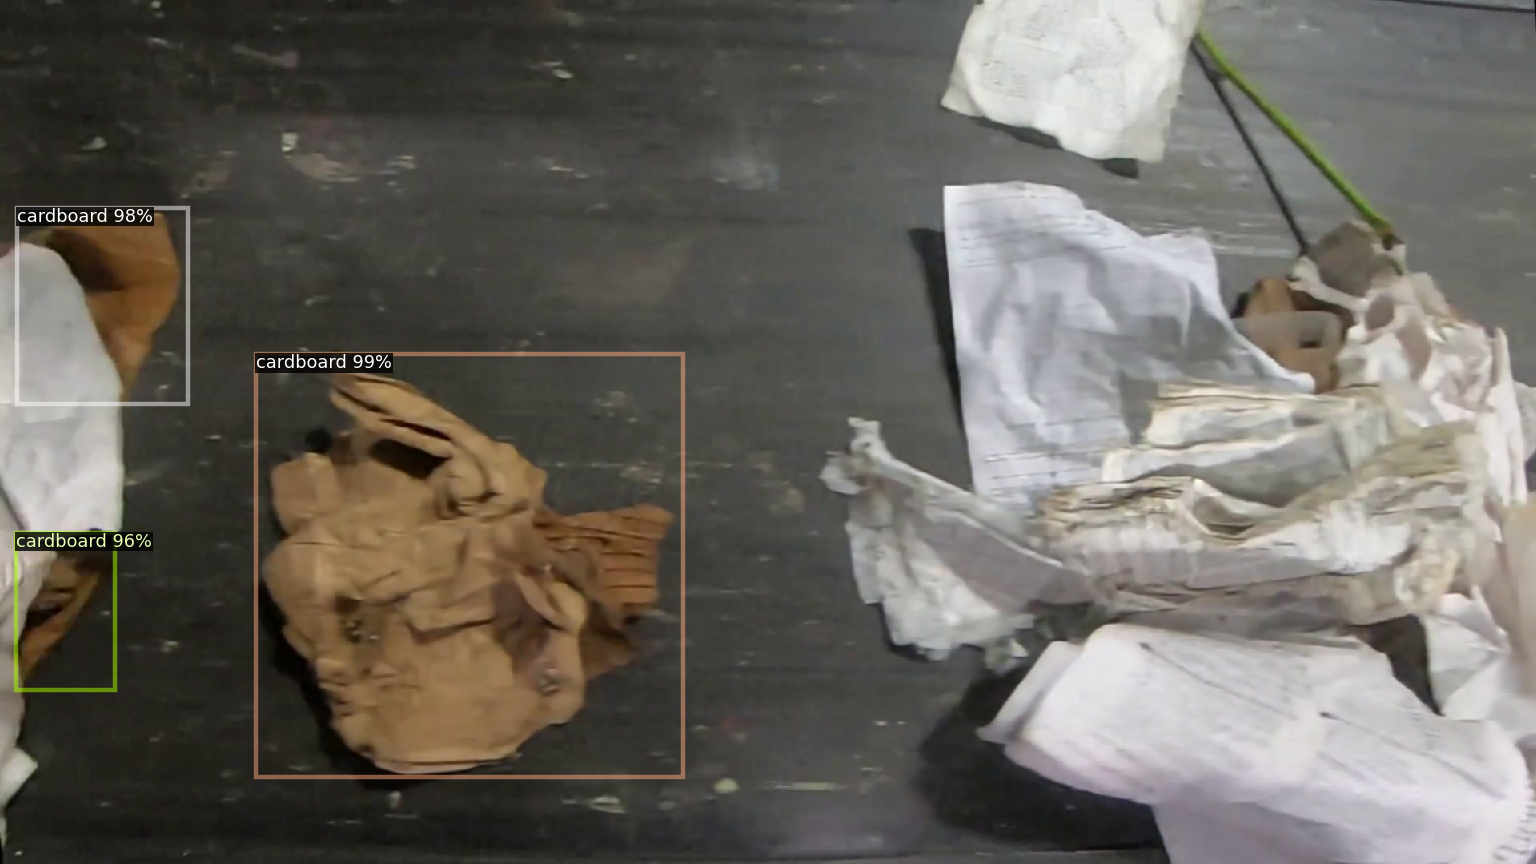

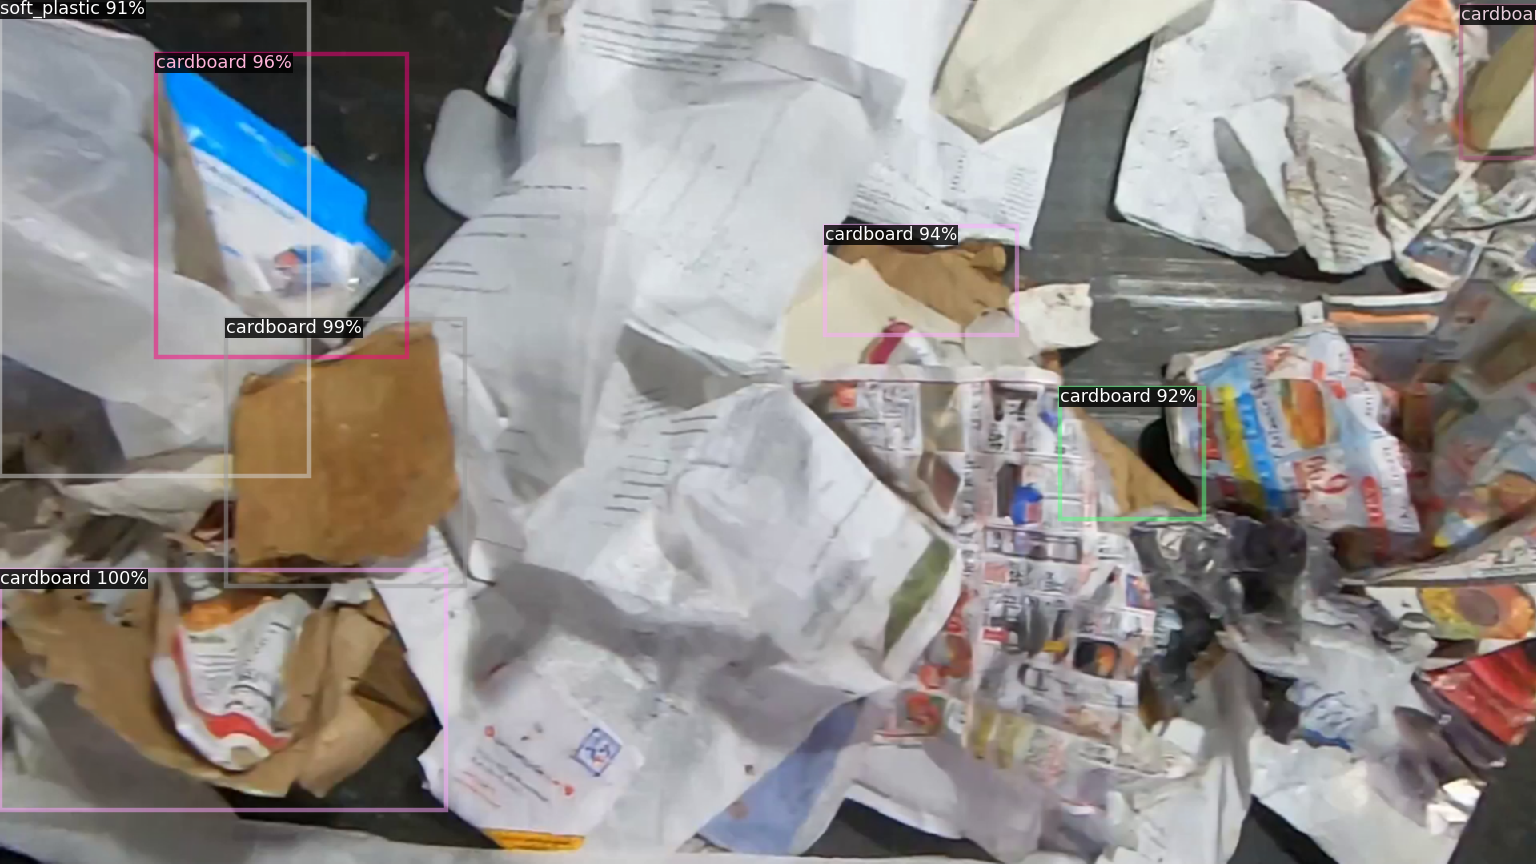

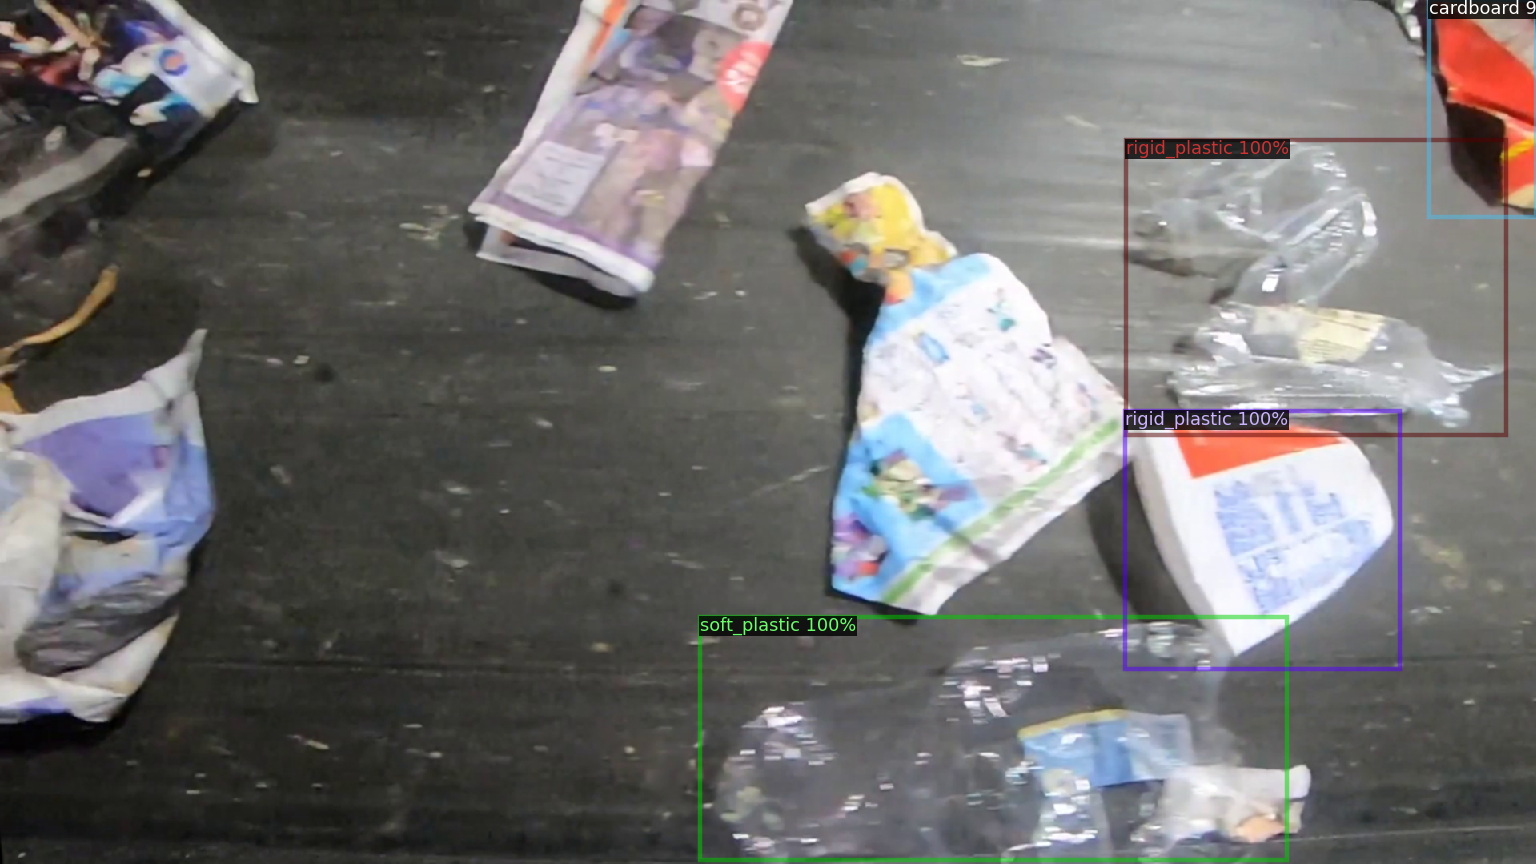

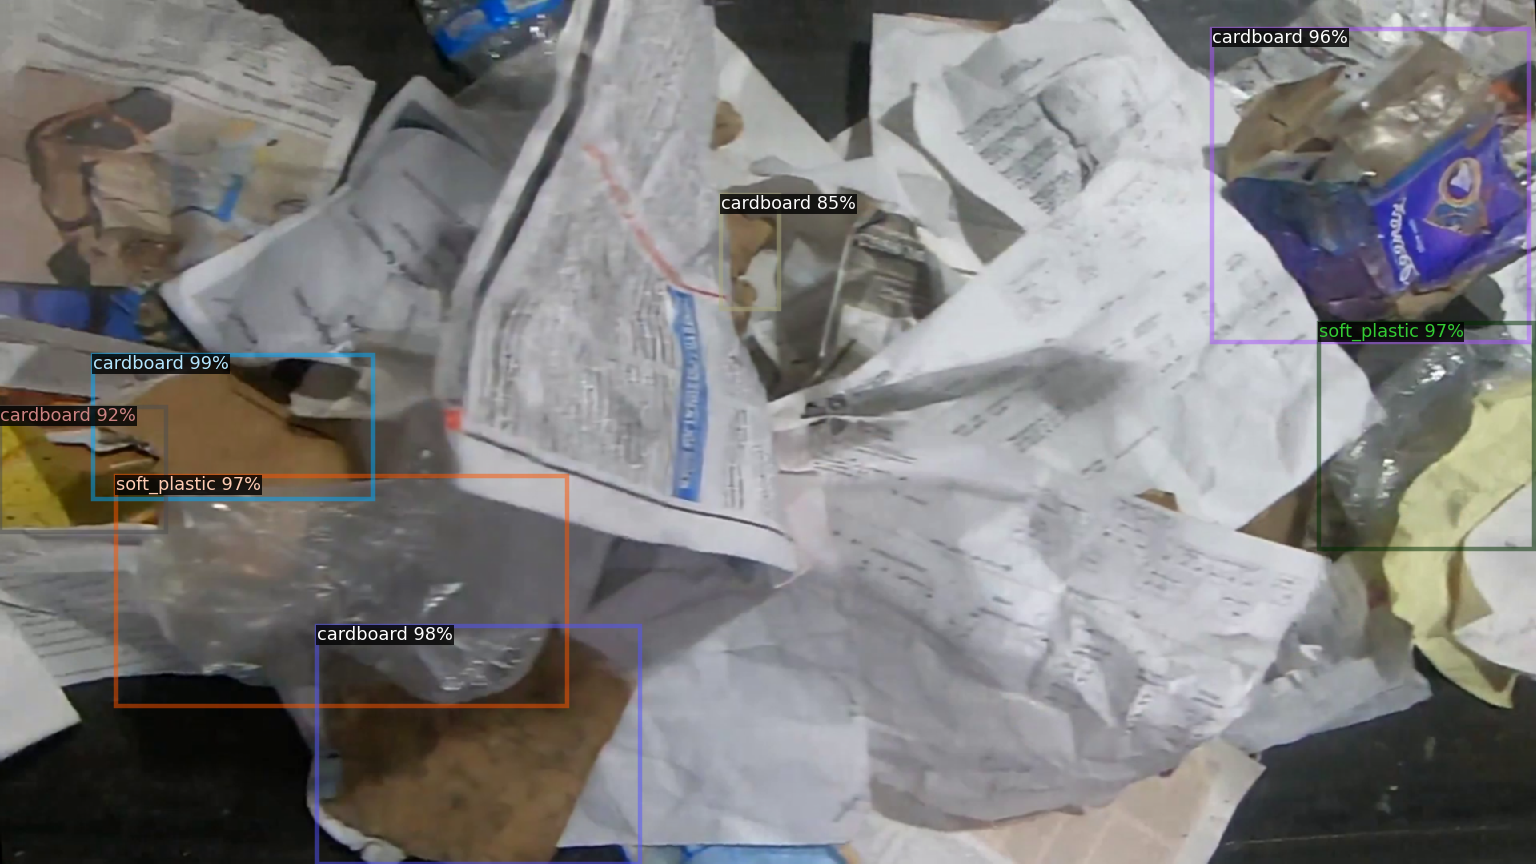

In [ ]:
import sys
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.engine import (
    default_argument_parser,
    default_setup,
    DefaultTrainer,
    launch,
)

# adding Folder_2 to the system path
sys.path.append('/content/detectron2_repo/projects/TridentNet')
from tridentnet import add_tridentnet_config

cfg = get_cfg()
add_tridentnet_config(cfg)
cfg.merge_from_file('/content/detectron2_repo/projects/TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml')
default_setup(cfg, '/content/detectron2_repo/projects/TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml')

cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ("zerowaste_test", )
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    # Filter out boxes under 50% confidence level
    instances = outputs["instances"]
    scores = instances.scores
    mask = scores >= 0.5
    instances = instances[mask]

    v = Visualizer(im[:, :, ::-1],
                   metadata=zerowaste_metadata_test,
                   scale=0.8,
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(instances.to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.set_new_allowed(True)
cfg.merge_from_file("/content/detectron2_repo/projects/TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml")
cfg.DATASETS.TRAIN = ("zerowaste_train",)
cfg.DATASETS.TEST = ("zerowaste_val",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/model_final_164568(1).pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.0005
cfg.SOLVER.MAX_ITER = 1000   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 300   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.set_new_allowed(True)
cfg.merge_from_file("/content/detectron2_repo/projects/TridentNet/configs/tridentnet_fast_R_50_C4_3x.yaml")
cfg.DATASETS.TRAIN = ("zerowaste_train",)
cfg.DATASETS.TEST = ("zerowaste_test",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.0005
cfg.SOLVER.MAX_ITER = 1000   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 300   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4


In [ ]:

cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ("zerowaste_test", )
predictor = DefaultPredictor(cfg)

KeyError: "No object named 'build_trident_resnet_backbone' found in 'BACKBONE' registry!"

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    # Filter out boxes under 50% confidence level
    instances = outputs["instances"]
    scores = instances.scores
    mask = scores >= 0.5
    instances = instances[mask]

    v = Visualizer(im[:, :, ::-1],
                   metadata=zerowaste_metadata_test,
                   scale=0.8,
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(instances.to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


In [ ]:
zerowaste_metadata

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))